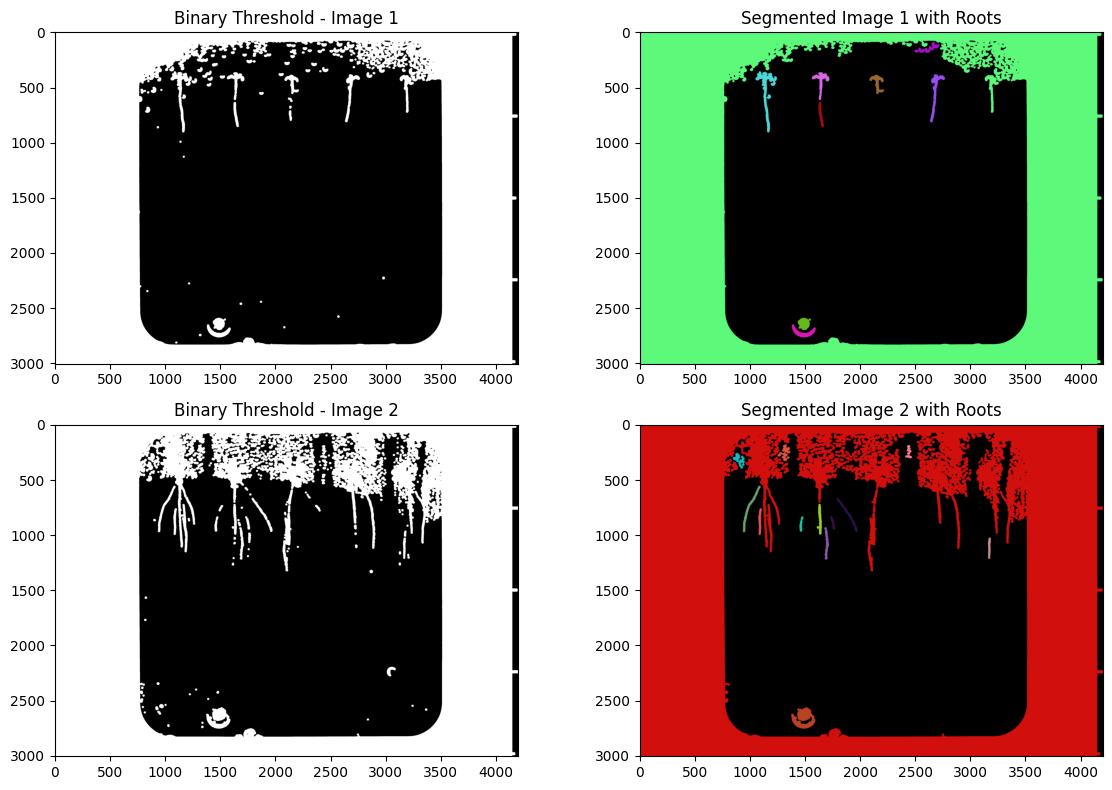

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def refined_segmentation(image, area_threshold=500, root_height_threshold=100, max_noise_area=70):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Thresholding to create binary mask
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Morphological operations to enhance roots
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilated = cv2.dilate(binary, kernel_dilate, iterations=3)
    closed = cv2.erode(dilated, kernel_erode, iterations=1)  # Reduce over-expanded regions
    
    # Use connectedComponentsWithStats to find components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed, connectivity=8)
    
    # Create an output image for segmented plants
    segmented = np.zeros_like(image)
    
    for label in range(1, num_labels):  # Skip the background label (0)
        x, y, w, h, area = stats[label]
        
        # Filter by area, height, width, and position
        if (
            area > area_threshold and
            h > root_height_threshold and
            y < image.shape[0] * 0.9 and
            w > 20  # Allow thinner objects to pass
        ):
            # Assign a unique color to each plant
            color = tuple(int(c) for c in np.random.choice(range(256), size=3))
            segmented[labels == label] = color
    
    return closed, segmented

# Load the images
image_1 = cv2.imread('task_3_image_1.png')
image_2 = cv2.imread('task_3_image_2.png')

# Apply the refined segmentation
binary_1, segmented_1 = refined_segmentation(image_1)
binary_2, segmented_2 = refined_segmentation(image_2)

# Display the results
plt.figure(figsize=(12, 8))

# For the first image
plt.subplot(2, 2, 1)
plt.title("Binary Threshold - Image 1")
plt.imshow(binary_1, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Segmented Image 1 with Roots")
plt.imshow(cv2.cvtColor(segmented_1, cv2.COLOR_BGR2RGB))

# For the second image
plt.subplot(2, 2, 3)
plt.title("Binary Threshold - Image 2")
plt.imshow(binary_2, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("Segmented Image 2 with Roots")
plt.imshow(cv2.cvtColor(segmented_2, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()

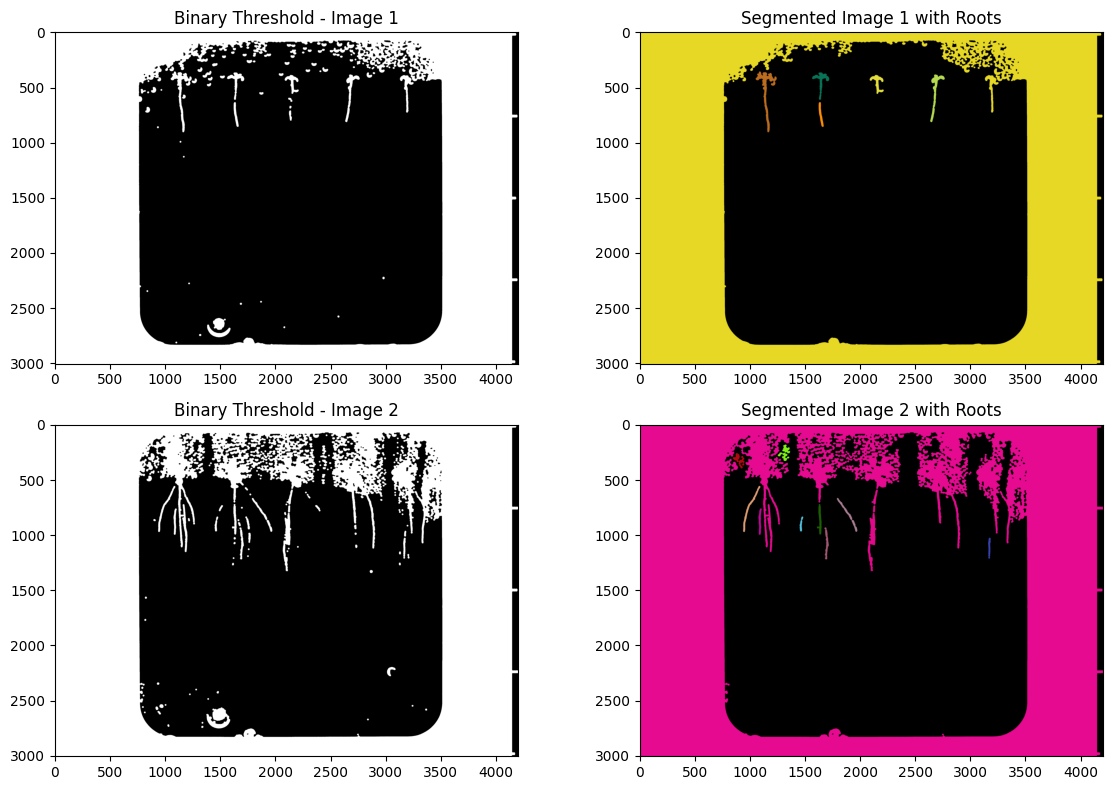

In [5]:
def optimized_segmentation(image, area_threshold=700, root_height_threshold=120, max_noise_area=30):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Thresholding to create binary mask
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Morphological operations
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilated = cv2.dilate(binary, kernel_dilate, iterations=3)
    eroded = cv2.erode(dilated, kernel_erode, iterations=2)
    
    # Use connectedComponentsWithStats to find components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded, connectivity=8)
    
    # Create an output image for segmented plants
    segmented = np.zeros_like(image)
    
    for label in range(1, num_labels):  # Skip the background label (0)
        x, y, w, h, area = stats[label]
        
        # Remove noise and filter objects
        if (
            area > area_threshold and
            h > root_height_threshold and
            w > 20 and
            y < image.shape[0] * 0.8
        ):
            # Assign a unique color to each plant
            color = tuple(int(c) for c in np.random.choice(range(256), size=3))
            segmented[labels == label] = color
    
    return eroded, segmented

# Apply the optimized segmentation
binary_1, segmented_1 = optimized_segmentation(image_1)
binary_2, segmented_2 = optimized_segmentation(image_2)

# Display results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title("Binary Threshold - Image 1")
plt.imshow(binary_1, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Segmented Image 1 with Roots")
plt.imshow(cv2.cvtColor(segmented_1, cv2.COLOR_BGR2RGB))

plt.subplot(2, 2, 3)
plt.title("Binary Threshold - Image 2")
plt.imshow(binary_2, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("Segmented Image 2 with Roots")
plt.imshow(cv2.cvtColor(segmented_2, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()


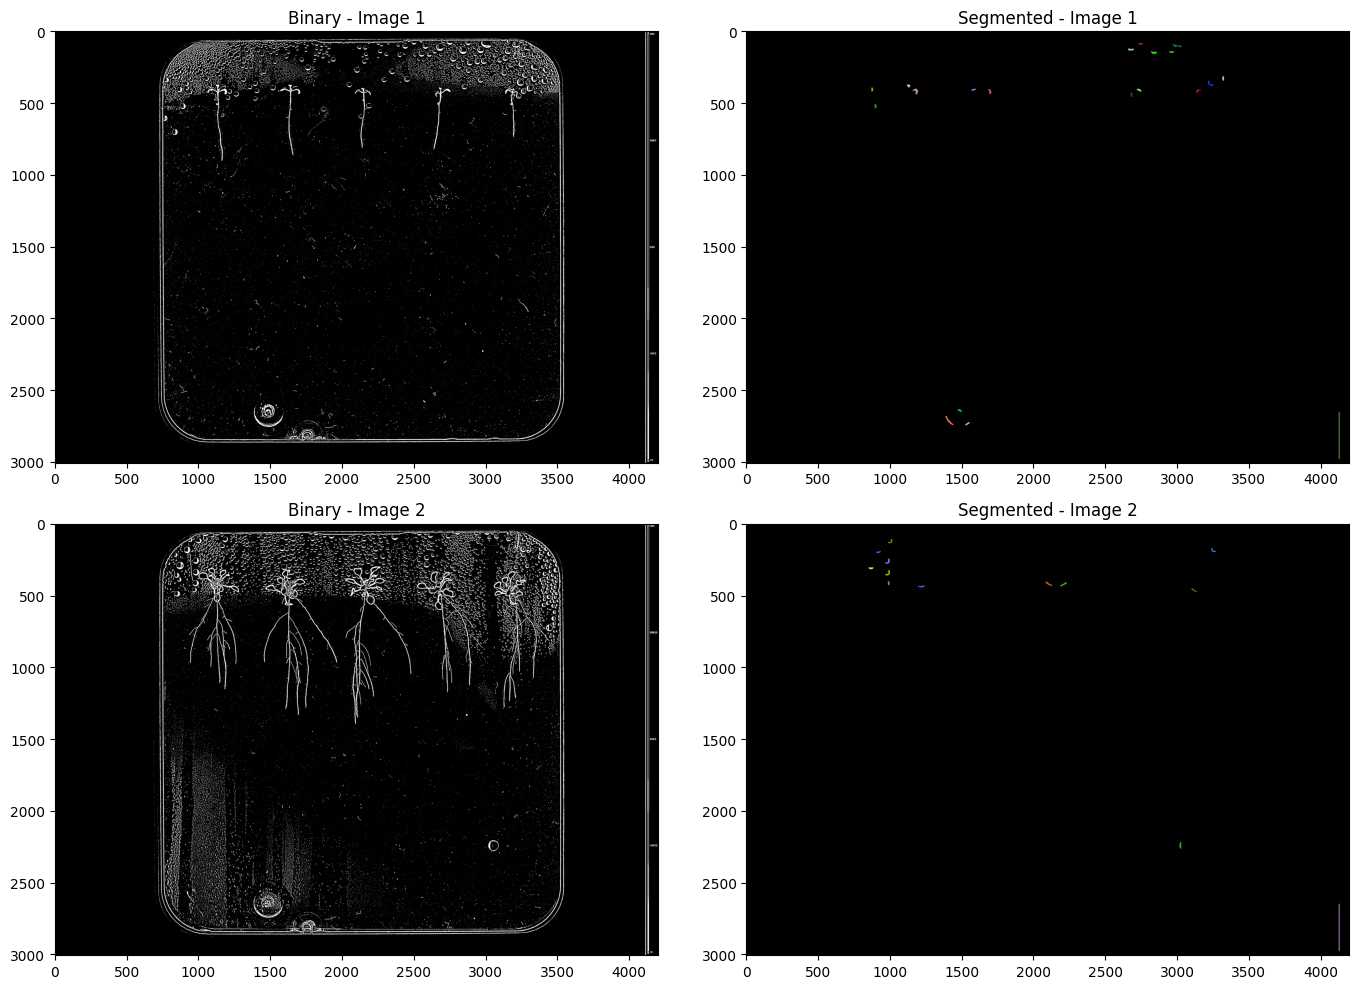

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Updated segmentation function using insights from the notebook
def improved_segment_plants(image, min_area=300, max_noise_area=50):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur for noise reduction
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Adaptive thresholding for better segmentation under varying lighting
    binary = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )
    
    # Morphological operations to refine segmentation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Connected components to identify individual plants
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opened, connectivity=8)
    
    # Create a blank image to visualize the segmented plants
    segmented = np.zeros_like(image)
    
    for label in range(1, num_labels):  # Exclude the background label (0)
        x, y, w, h, area = stats[label]
        
        # Filter out noise and small objects
        if area < min_area or area < max_noise_area:
            continue
        
        # Assign a random color for visualization
        color = tuple(np.random.randint(0, 255, size=3).tolist())
        segmented[labels == label] = color
    
    return binary, segmented

# Load the provided images
image_1_path = 'task_3_image_1.png'
image_2_path = 'task_3_image_2.png'

image_1 = cv2.imread(image_1_path)
image_2 = cv2.imread(image_2_path)

# Apply the improved segmentation function to both images
binary_1, segmented_1 = improved_segment_plants(image_1)
binary_2, segmented_2 = improved_segment_plants(image_2)

# Visualize the results
plt.figure(figsize=(14, 10))

# Binary result for image 1
plt.subplot(2, 2, 1)
plt.title("Binary - Image 1")
plt.imshow(binary_1, cmap='gray')

# Segmented result for image 1
plt.subplot(2, 2, 2)
plt.title("Segmented - Image 1")
plt.imshow(cv2.cvtColor(segmented_1, cv2.COLOR_BGR2RGB))

# Binary result for image 2
plt.subplot(2, 2, 3)
plt.title("Binary - Image 2")
plt.imshow(binary_2, cmap='gray')

# Segmented result for image 2
plt.subplot(2, 2, 4)
plt.title("Segmented - Image 2")
plt.imshow(cv2.cvtColor(segmented_2, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()


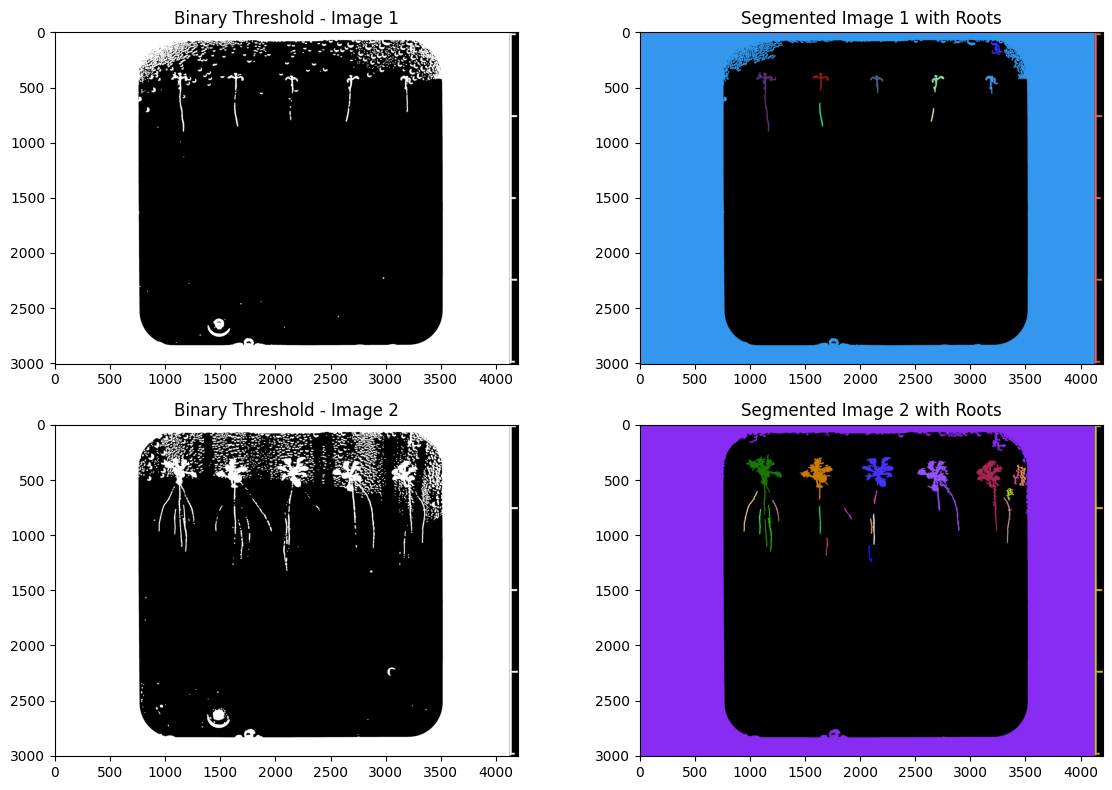

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_plants_with_roots(image, area_threshold=300, root_height_threshold=100, max_noise_area=50):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Thresholding to create binary mask
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Morphological operations to enhance roots
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilated = cv2.dilate(binary, kernel, iterations=2)
    
    # Use connectedComponentsWithStats to find components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilated, connectivity=8)
    
    # Create an output image for segmented plants
    segmented = np.zeros_like(image)
    
    for label in range(1, num_labels):  # Skip the background label (0)
        x, y, w, h, area = stats[label]
        
        # Remove small noise
        if area < max_noise_area:
            continue
        
        # Filter objects by area, height, and ensure they are tall (plants + roots)
        if area > area_threshold and h > root_height_threshold and y < image.shape[0] * 0.7 and w > 20:
            # Assign a unique color to each plant
            color = tuple(int(c) for c in np.random.choice(range(256), size=3))
            segmented[labels == label] = color
    
    return dilated, segmented

# Load the images
image_1 = cv2.imread('task_3_image_1.png')
image_2 = cv2.imread('task_3_image_2.png')

# Apply the updated segmentation to both images
binary_1, segmented_1 = segment_plants_with_roots(image_1)
binary_2, segmented_2 = segment_plants_with_roots(image_2)

# Display the results
plt.figure(figsize=(12, 8))

# For the first image
plt.subplot(2, 2, 1)
plt.title("Binary Threshold - Image 1")
plt.imshow(binary_1, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Segmented Image 1 with Roots")
plt.imshow(cv2.cvtColor(segmented_1, cv2.COLOR_BGR2RGB))

# For the second image
plt.subplot(2, 2, 3)
plt.title("Binary Threshold - Image 2")
plt.imshow(binary_2, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("Segmented Image 2 with Roots")
plt.imshow(cv2.cvtColor(segmented_2, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()

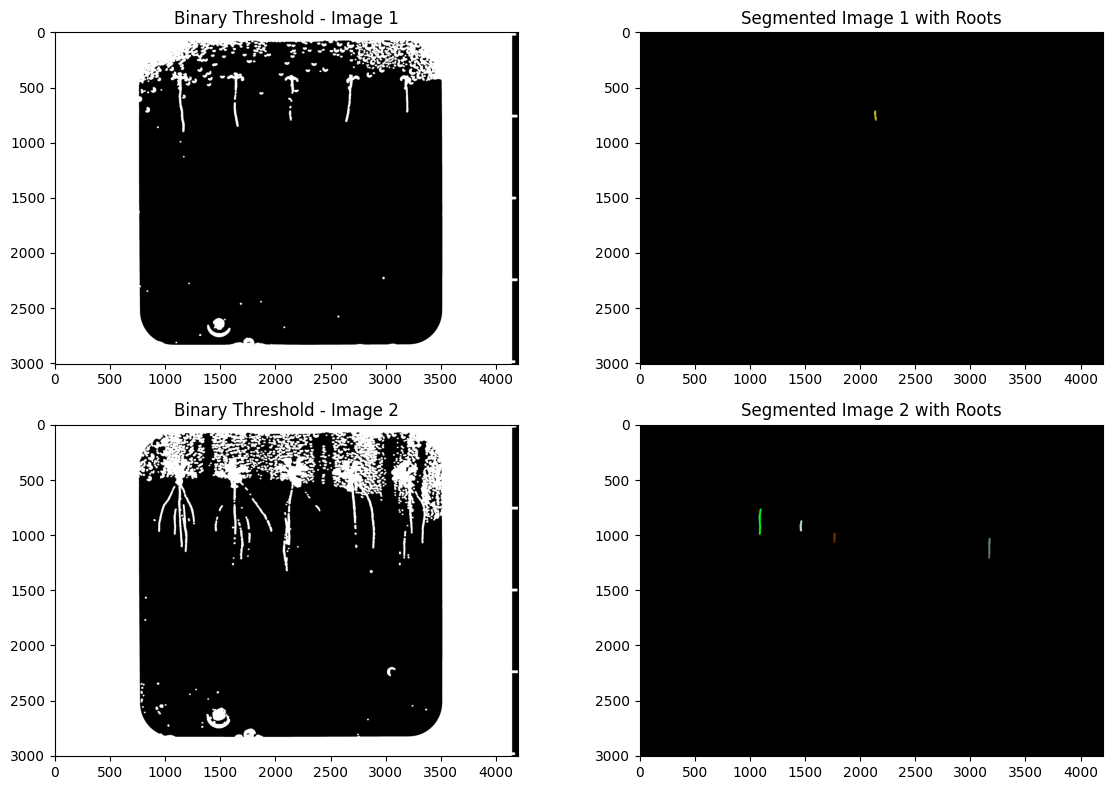

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_plants_with_roots_optimized(image, area_threshold=350, root_height_threshold=90, max_noise_area=30):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Thresholding to create binary mask
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Morphological operations to enhance roots
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated = cv2.dilate(binary, kernel_dilate, iterations=3)
    eroded = cv2.erode(dilated, kernel_erode, iterations=1)
    
    # Use connectedComponentsWithStats to find components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded, connectivity=8)
    
    # Create an output image for segmented plants
    segmented = np.zeros_like(image)
    
    for label in range(1, num_labels):  # Skip the background label (0)
        x, y, w, h, area = stats[label]
        aspect_ratio = h / w if w > 0 else 0  # Height to width ratio
        
        # Filter by area, height, and shape
        if (
            area > area_threshold and
            h > root_height_threshold and
            area / (w * h) > 0.5 and  # Solidity
            aspect_ratio > 1.5 and  # Ensure tall objects
            w > 15
        ):
            # Assign a unique color to each plant
            color = tuple(int(c) for c in np.random.choice(range(256), size=3))
            segmented[labels == label] = color
    
    return eroded, segmented

# Load the images
image_1 = cv2.imread('task_3_image_1.png')
image_2 = cv2.imread('task_3_image_2.png')

# Apply the optimized segmentation to both images
binary_1, segmented_1 = segment_plants_with_roots_optimized(image_1)
binary_2, segmented_2 = segment_plants_with_roots_optimized(image_2)

# Display the results
plt.figure(figsize=(12, 8))

# For the first image
plt.subplot(2, 2, 1)
plt.title("Binary Threshold - Image 1")
plt.imshow(binary_1, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Segmented Image 1 with Roots")
plt.imshow(cv2.cvtColor(segmented_1, cv2.COLOR_BGR2RGB))

# For the second image
plt.subplot(2, 2, 3)
plt.title("Binary Threshold - Image 2")
plt.imshow(binary_2, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("Segmented Image 2 with Roots")
plt.imshow(cv2.cvtColor(segmented_2, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()


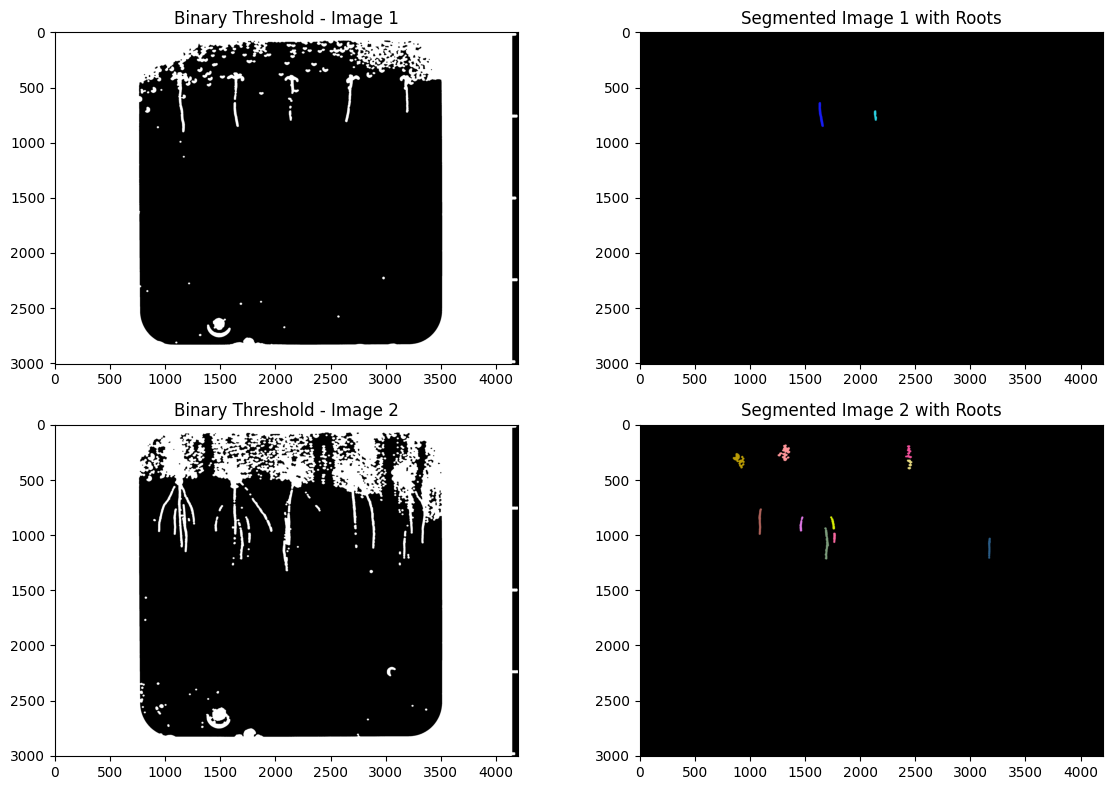

In [11]:
def segment_plants_with_roots_refined(image, area_threshold=250, root_height_threshold=80, max_noise_area=10):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Thresholding to create binary mask
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Morphological operations to enhance roots
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilated = cv2.dilate(binary, kernel_dilate, iterations=3)
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel_close, iterations=2)
    
    # Use connectedComponentsWithStats to find components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed, connectivity=8)
    
    # Create an output image for segmented plants
    segmented = np.zeros_like(image)
    
    for label in range(1, num_labels):  # Skip the background label (0)
        x, y, w, h, area = stats[label]
        aspect_ratio = h / w if w > 0 else 0  # Height to width ratio
        
        # Filter by area, height, and shape
        if (
            area > area_threshold and
            h > root_height_threshold and
            w > 10 and  # Minimum width
            aspect_ratio > 1.2 and  # Ensure tall objects
            area / (w * h) > 0.4  # Solidity
        ):
            # Assign a unique color to each plant
            color = tuple(int(c) for c in np.random.choice(range(256), size=3))
            segmented[labels == label] = color
    
    return closed, segmented

# Применение нового подхода
binary_1, segmented_1 = segment_plants_with_roots_refined(image_1)
binary_2, segmented_2 = segment_plants_with_roots_refined(image_2)

# Визуализация результата
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title("Binary Threshold - Image 1")
plt.imshow(binary_1, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Segmented Image 1 with Roots")
plt.imshow(cv2.cvtColor(segmented_1, cv2.COLOR_BGR2RGB))

plt.subplot(2, 2, 3)
plt.title("Binary Threshold - Image 2")
plt.imshow(binary_2, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("Segmented Image 2 with Roots")
plt.imshow(cv2.cvtColor(segmented_2, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()


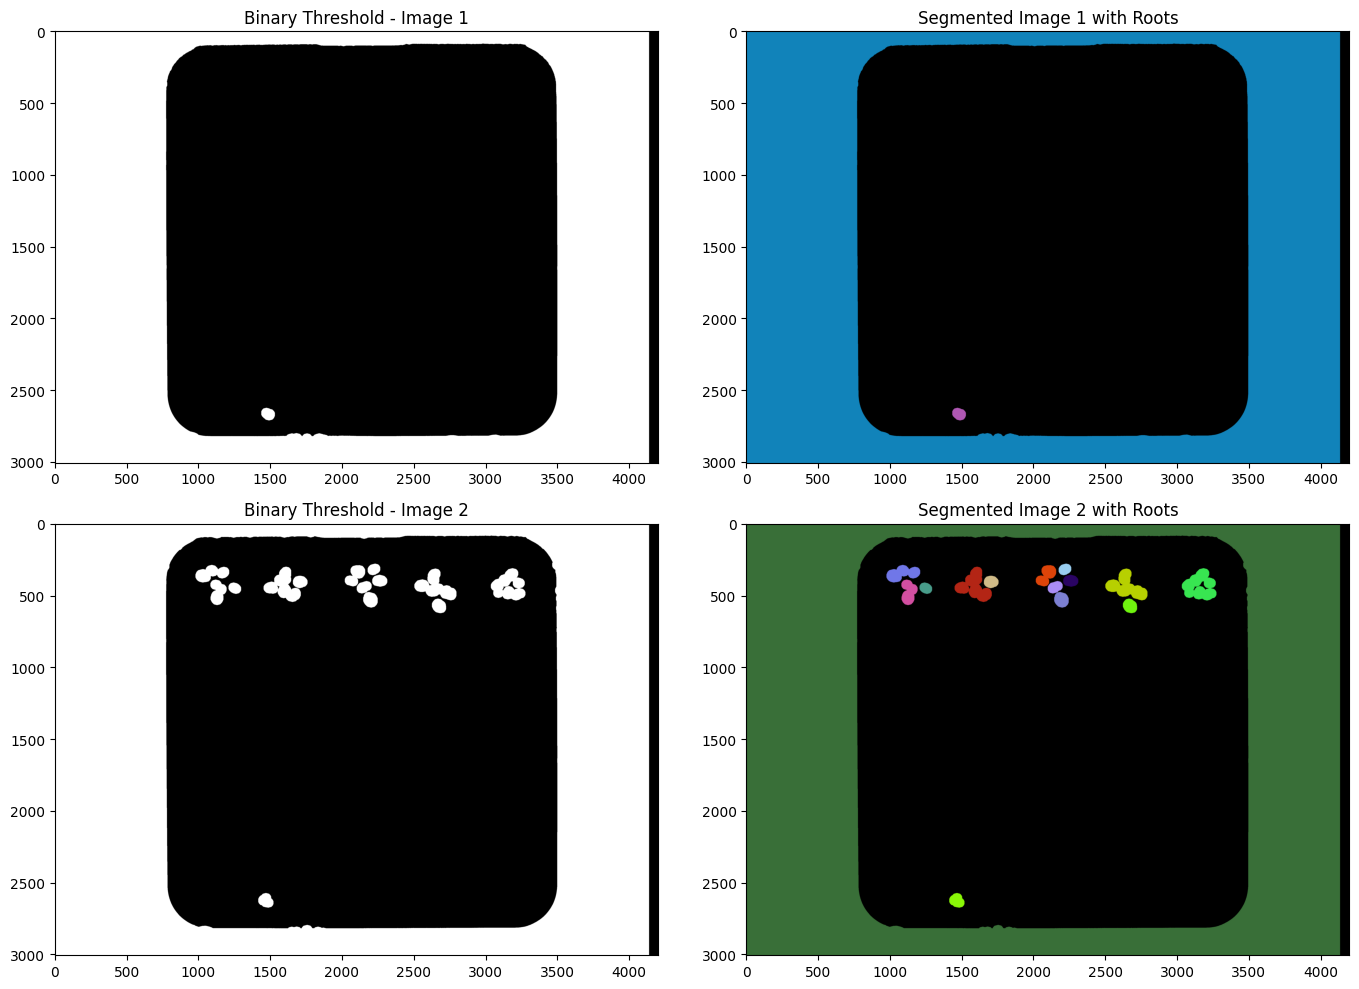

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_plants_with_roots(image, min_area=300, max_noise_area=50, kernel_size=(15, 15), dilate_iterations=3):
    # Конвертация в оттенки серого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Усиление контраста
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Бинаризация с порогом
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Устранение мелкого шума с помощью морфологии
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Соединение корней и растений
    dilated = cv2.dilate(cleaned, kernel, iterations=dilate_iterations)
    
    # Получение компонентов
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilated, connectivity=8)
    
    # Создание изображения для визуализации
    segmented = np.zeros_like(image)
    
    for label in range(1, num_labels):  # Пропускаем фон (label=0)
        x, y, w, h, area = stats[label]
        
        # Исключаем мелкий шум
        if area < max_noise_area:
            continue
        
        # Условие для фильтрации крупных объектов
        if area > min_area:
            color = tuple(np.random.randint(0, 255, size=3).tolist())
            segmented[labels == label] = color
    
    return dilated, segmented

# Загрузка изображений
image_1 = cv2.imread('task_3_image_1.png')
image_2 = cv2.imread('task_3_image_2.png')

# Применение сегментации
binary_1, segmented_1 = segment_plants_with_roots(image_1)
binary_2, segmented_2 = segment_plants_with_roots(image_2)

# Визуализация
plt.figure(figsize=(14, 10))

# Первая картинка
plt.subplot(2, 2, 1)
plt.title("Binary Threshold - Image 1")
plt.imshow(binary_1, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Segmented Image 1 with Roots")
plt.imshow(cv2.cvtColor(segmented_1, cv2.COLOR_BGR2RGB))

# Вторая картинка
plt.subplot(2, 2, 3)
plt.title("Binary Threshold - Image 2")
plt.imshow(binary_2, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("Segmented Image 2 with Roots")
plt.imshow(cv2.cvtColor(segmented_2, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()